# 01. EDA

## Imports

In [34]:
from csv import DictReader
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline

In [3]:
import matplotlib
matplotlib.get_configdir()

'/Users/Michael/.matplotlib'

In [37]:
DATA_RAW = Path("../data/raw/")
DATA_INT = Path("../data/interim/")
DATA_PRO = Path("../data/processed/")
STOPWORDS = set(nltk.corpus.stopwords.words("english"))
SENTANCES1_STEMS = {
    "S1": "One should never trust ",
    "S2": "The good life ",
    "S3": "Brothers ",
    "S4": "Sisters ",
    "S5": "The beauty of ",
    "S6": "Lacking everything but "
}

sns.set_style("whitegrid")
plt.rcParams.update(
    {
        "axes.labelsize": 16,
        "axes.titlepad": 16,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "figure.figsize": (12, 12),
        "figure.titlesize": 24,
        "figure.titleweight": "bold",
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
    }
)

## Data Setup

### `mbti_1.csv`

In [5]:
mbti = {}
with open(DATA_RAW.joinpath("mbti_1.csv"), "r") as csvfile:
    reader = DictReader(csvfile)
    for i, row in enumerate(reader):
        # if more than 3 pipes in a row, sub with 3
        posts = re.sub(r"\|{4,}", r"\|\|\|", row["posts"])
        mbti[i] = {"type": row["type"]}
        mbti[i].update(
            {f"post_{p:02}": post for p, post in enumerate(posts.split("|||"))}
        )

# mbti = pd.DataFrame.from_dict(mbti, orient="index").drop("post_50", axis=1)
mbti = (
    pd.melt(
        pd.DataFrame.from_dict(mbti, orient="index").drop("post_50", axis=1)
        .reset_index()
        .rename(columns={"index": "uid"}),
        id_vars=["uid", "type"],
        var_name="post",
        value_name="text",
    )
    .sort_values(["uid", "post"])
    .set_index(["uid", "type"])
)

mbti


post                                               text
uid  type                                                            
0    INFJ  post_00        'http://www.youtube.com/watch?v=qsXHcwe3krw
     INFJ  post_01  http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
     INFJ  post_02  enfp and intj moments  https://www.youtube.com...
     INFJ  post_03  What has been the most life-changing experienc...
     INFJ  post_04  http://www.youtube.com/watch?v=vXZeYwwRDw8   h...
...            ...                                                ...
8674 INFP  post_45  I was going to close my facebook a few months ...
     INFP  post_46  30 Seconds to Mars - All of my collections. It...
     INFP  post_47  I have seen it, and i agree. I did actually th...
     INFP  post_48  Ok so i have just watched Underworld 4 (Awaken...
     INFP  post_49  I would never want to turn off my emotions. so...

[433750 rows x 2 columns]

### `essays.csv`

In [ ]:
col_order = ["#AUTHID", "TEXT", "cAGR", "cCON", "cEXT", "cNEU", "cOPN"]

essays = pd.read_csv(
    DATA_RAW.joinpath("essays.csv"),
    encoding="cp1252",
    converters={
        k: lambda x: True if x == "y" else False
        for k in ["cEXT", "cNEU", "cAGR", "cCON", "cOPN"]
    }
)[col_order].rename(
    columns={
        "#AUTHID": "uid",
        "TEXT": "text",
        "cEXT": "ext",
        "cNEU": "neu",
        "cAGR": "agr",
        "cCON": "con",
        "cOPN": "opn",
    }
)
essays["uid"] = essays.transform({"uid": lambda x: x.split(".")[0]})
essays["typestr"] = (
    essays.iloc[:, 2:]
    .apply(
        lambda r: "|".join(sorted(map(lambda x: x[0].upper(), r.index[r]))) if r.any() else "-",
        axis=1,
    )
    .astype("category")
)

essays = essays.set_index("uid")
essays

### `SENTANCES1`

In [ ]:
sent1 = pd.read_csv(DATA_RAW.joinpath("SENTANCES1/data1.csv")).rename(
    columns={"EX": "ext_f", "NR": "neu_f", "OP": "opn_f", "AG": "agr_f", "CN": "con_f"}
)

sent1[sent1.columns[-5:]] = sent1.agg(
    {
        k: lambda x: np.divide(
            np.subtract(x, sent1[k].min()), sent1[k].max() - sent1[k].min()
        )
        for k in sent1.columns[-5:]
    }
)

sent1 = sent1[sent1.columns[:-5].append(sent1.columns[-5:].sort_values())].assign(
    agr=lambda r: r["agr_f"] >= 0.5,
    con=lambda r: r["con_f"] >= 0.5,
    ext=lambda r: r["ext_f"] >= 0.5,
    neu=lambda r: r["neu_f"] >= 0.5,
    opn=lambda r: r["opn_f"] >= 0.5,
)

sent1["typestr"] = (
    sent1[["agr", "con", "ext", "neu", "opn"]]
    .apply(
        lambda r: "|".join(sorted(map(lambda x: x[0].upper(), r.index[r]))) if r.any() else "-",
        axis=1,
    )
    .astype("category")
)

sent1


## Exploration

In [ ]:
count_vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words("english"), ngram_range=(1, 4))
stemmer = 

### `mbti_1.csv`

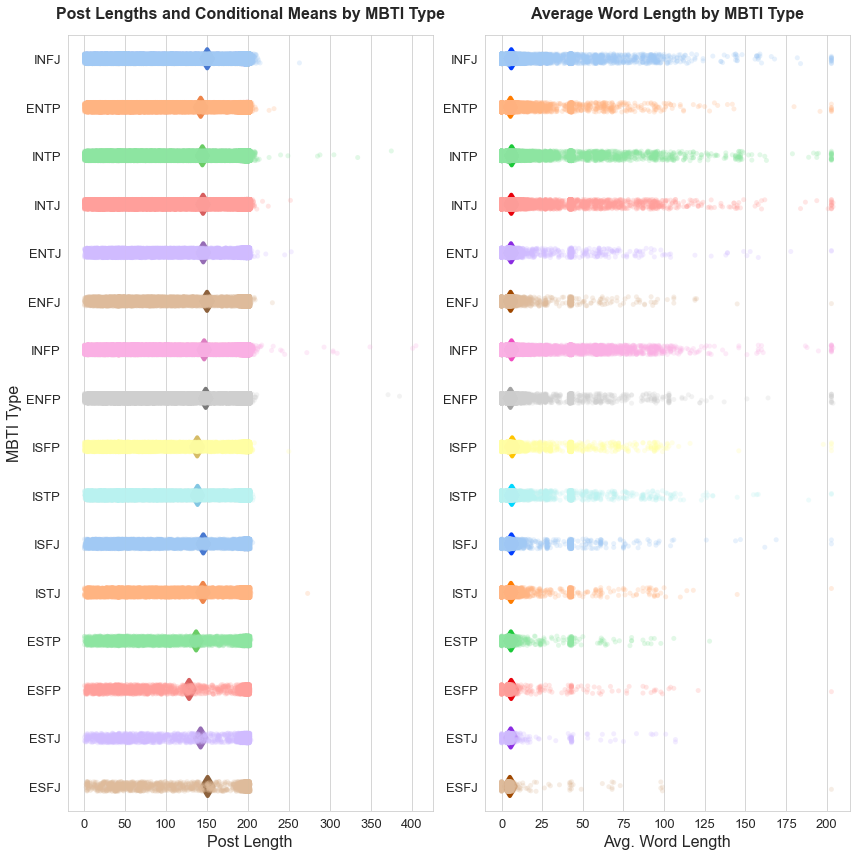

In [6]:
fig, ax = plt.subplots(1, 2)

sns.stripplot(
    x=mbti.text.str.len(),
    y=mbti.index.get_level_values("type"),
    palette="pastel",
    dodge=True,
    alpha=0.25,
    ax=ax[0],
)

sns.pointplot(
    x=mbti.text.str.len(),
    y=mbti.index.get_level_values("type"),
    palette="muted",
    markers="d",
    scale=2,
    join=False,
    ax=ax[0]
)

ax[0].set_xlabel("Post Length")
ax[0].set_ylabel("MBTI Type")
ax[0].set_title("Post Lengths and Conditional Means by MBTI Type")

sns.stripplot(
    x=mbti.apply(lambda r: 0 if pd.isna(r["text"]) else len(r["text"].replace(" ", ""))/len(r["text"].split()), axis=1),
    y=mbti.index.get_level_values("type"),
    palette="pastel",
    dodge=True,
    alpha=0.25,
    ax=ax[1],
)

sns.pointplot(
    x=mbti.apply(lambda r: 0 if pd.isna(r["text"]) else len(r["text"].replace(" ", ""))/len(r["text"].split()), axis=1),
    y=mbti.index.get_level_values("type"),
    palette="bright",
    markers="d",
    scale=2,
    join=False,
    ax=ax[1],
)

ax[1].set_xlabel("Avg. Word Length")
ax[1].set_ylabel("")
ax[1].set_title("Average Word Length by MBTI Type")
fig.tight_layout();

### `essays.csv`

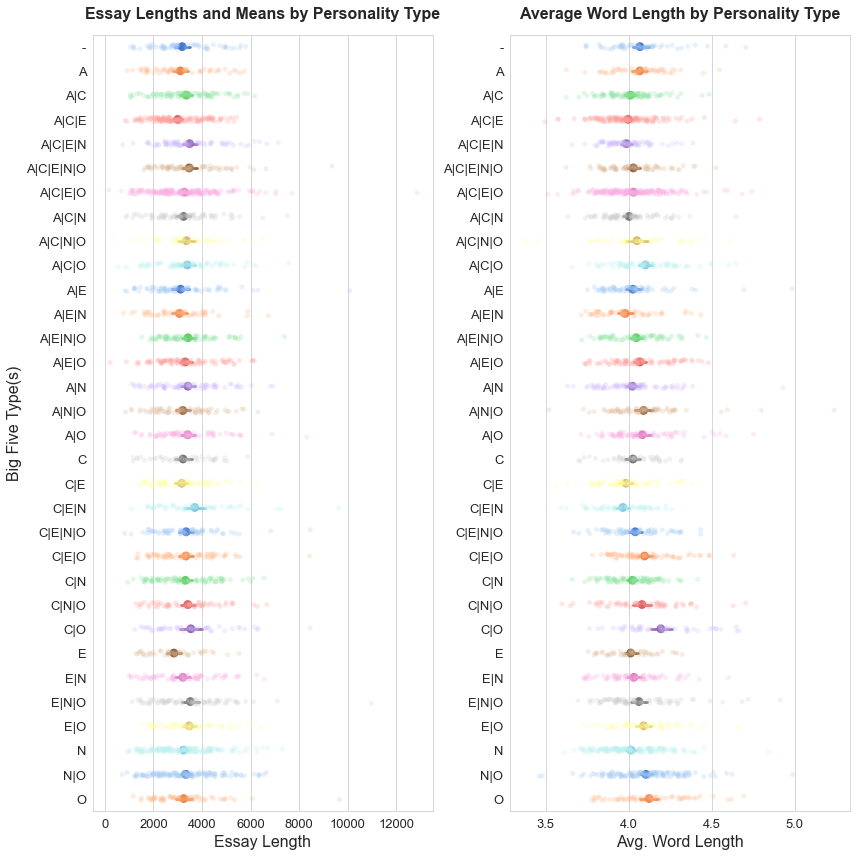

In [8]:
fig, ax = plt.subplots(1, 2)

sns.stripplot(
    x=essays["text"].agg(len),
    y=essays["typestr"],
    palette="pastel",
    dodge=True,
    alpha=0.25,
    ax=ax[0],
)

sns.pointplot(
    x=essays["text"].agg(len),
    y=essays["typestr"],
    palette="muted",
    join=False,
    ax=ax[0]
)

ax[0].set_xlabel("Essay Length")
ax[0].set_ylabel("Big Five Type(s)")
ax[0].set_title("Essay Lengths and Means by Personality Type")

sns.stripplot(
    x=essays.apply(lambda r: len(r["text"].replace(" ", ""))/len(r["text"].split()), axis=1),
    y=essays["typestr"],
    palette="pastel",
    dodge=True,
    alpha=0.25,
    ax=ax[1],
)

sns.pointplot(
    x=essays.apply(lambda r: len(r["text"].replace(" ", ""))/len(r["text"].split()), axis=1),
    y=essays["typestr"],
    palette="muted",
    join=False,
    ax=ax[1],
)

ax[1].set_xlabel("Avg. Word Length")
ax[1].set_ylabel("")
ax[1].set_title("Average Word Length by Personality Type")
fig.tight_layout();

### SENTANCES1

In [14]:
sent1[SENTANCES1_STEMS.keys()].dropna().applymap(lambda x: len(x.split())).mean(axis=1)

0      3.833333
1      4.666667
2      3.166667
3      6.000000
4      2.166667
         ...   
927    6.000000
928    2.833333
929    4.333333
930    2.000000
932    5.333333
Length: 830, dtype: float64

In [28]:
sent1[SENTANCES1_STEMS.keys()].dropna(subset=SENTANCES1_STEMS.keys()).iloc[[288, 312, 719, 815]]

,S1,S2,S3,S4,S5,S6
318,a liar.,means being at peace with your choices.,are invaluable.,are invaluable.,everything all the time.,love.
346,Greeks bearing gifts,is la vita bella,in arms,of mercy,the individual is in the eye of the beholder,common sense
804,raincoats.,is easier than this one.,should be banned.,should exist.,everything is nothing.,"happiness, you would still be rich."
916,statistics,doesn't exist,are protectors.,are a pain.,things.,hope.


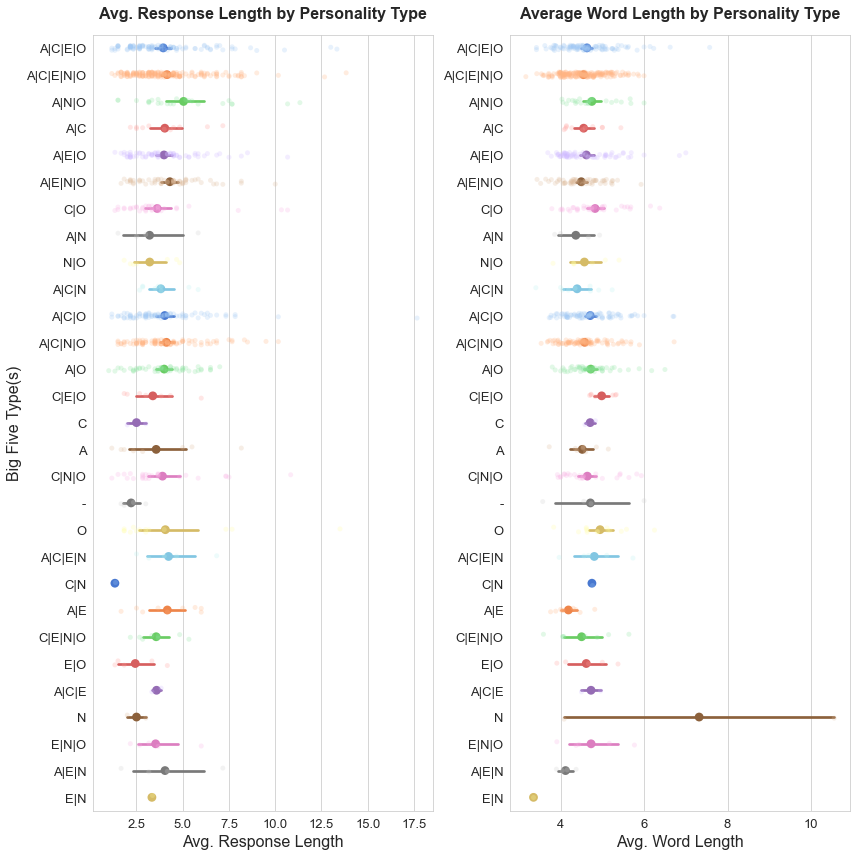

In [26]:
fig, ax = plt.subplots(1, 2)
all_text = sent1[SENTANCES1_STEMS.keys()].dropna(subset=SENTANCES1_STEMS.keys()).agg(" ".join, axis=1).dropna()
avg_textlen = sent1[SENTANCES1_STEMS.keys()].dropna(subset=SENTANCES1_STEMS.keys()).applymap(lambda x: len(x.split())).mean(axis=1).dropna()

sns.stripplot(
    x=avg_textlen,
    y=sent1.loc[avg_textlen.index, "typestr"].astype(str),
    palette="pastel",
    dodge=True,
    alpha=0.25,
    ax=ax[0],
)

sns.pointplot(
    x=avg_textlen,
    y=sent1.loc[avg_textlen.index, "typestr"].astype(str),
    palette="muted",
    join=False,
    ax=ax[0],
)

ax[0].set_xlabel("Avg. Response Length")
ax[0].set_ylabel("Big Five Type(s)")
ax[0].set_title("Avg. Response Length by Personality Type")

sns.stripplot(
    x=all_text.apply(
        lambda r: len(r.replace(" ", "")) / len(r.split())
    ),
    y=sent1.loc[all_text.index, "typestr"].astype(str),
    palette="pastel",
    dodge=True,
    alpha=0.25,
    ax=ax[1],
)

sns.pointplot(
    x=all_text.apply(
        lambda r: len(r.replace(" ", "")) / len(r.split())
    ),
    y=sent1.loc[all_text.index, "typestr"].astype(str),
    palette="muted",
    join=False,
    ax=ax[1],
)

ax[1].set_xlabel("Avg. Word Length")
ax[1].set_ylabel("")
ax[1].set_title("Average Word Length by Personality Type")
fig.tight_layout()


In [29]:
sent1[sent1["typestr"] == "N"]

,gender,age,S1,S2,S3,S4,S5,S6,agr_f,con_f,ext_f,neu_f,opn_f,agr,con,ext,neu,opn,typestr
288,1,25,NaN,NaN,NaN,NaN,NaN,NaN,0.384615,0.384615,0.487179,0.794872,0.282051,False,False,False,True,False,N
312,2,37,anyone,yes indeed,are a pain,are a pain,life,have everything,0.487179,0.410256,0.230769,0.512821,0.461538,False,False,False,True,False,N
719,2,20,ÑÐµÐºÑ€ÐµÑ‚Ñ‹ ÐºÐ¾Ñ‚Ð¾Ñ€Ñ‹Ðµ Ð´Ð¾Ð²ÐµÑ€Ð¸Ð»Ð¸...,"Ð²ÑÐµÐ³Ð´Ð° Ð³Ð¾Ñ‚Ð¾Ð², ÑÑ‚Ñ€ÐµÐ¼Ð»ÑŽÑÑŒ",ÐµÑÑ‚ÑŒ 2,ÐµÑÑ‚ÑŒ 1,"Ñ‚ÐµÐ»ÐµÑÐ½Ð°Ñ Ð²Ñ€ÐµÐ¼ÐµÐ½Ð½Ð°Ñ , Ð”Ð£Ð¥Ðž...",Ñ ÑÑ‡Ð°ÑÑ‚Ð»Ð¸Ð²Ð°,0.282051,0.435897,0.410256,0.512821,0.230769,False,False,False,True,False,N
815,2,30,NaN,NaN,NaN,NaN,NaN,NaN,0.384615,0.384615,0.487179,0.589744,0.333333,False,False,False,True,False,N
